# Project Name: Lyric Generator
Description:
Implementing a Deep Neural network using LSTMs to create a character based lyric generator

Details:
1. step size: 5
2. batch size: 32
3. Epochs: 10

### Importing Libraries

In [26]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Activation,LSTM,Dense,CuDNNLSTM, Flatten, Bidirectional, Dropout
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
import os
import matplotlib.pyplot as plt
import re
import pandas as pd
np.random.seed(10)

### Design Parameters

In [27]:
BATCH_SIZE = 32
maxlen = 5 ##timesteps
epochs = 10
MIN_WORD_FREQUENCY = 10

In [28]:
def load_lyrics(path):
    '''
    Function to load lyrics of all the artists in the input path
    '''
    lyrics = ""
    for fn in os.listdir(path):
        with open(os.path.join(path, fn), 'r') as song:
            song_lyrics = clean_string(song.read())
            lyrics += song_lyrics
    return lyrics

def clean_string(string):
    """
    Cleans unwanted characters and words from string.
    @param string: The string to be cleaned.
    @return: The cleaned string.
    """
    string = string.lower()  # lowercase

    clean_words = []
    for word in string.split():
#         if(word and (word[0] == "[" and word[-1] == "]")\
#            or (word[0] == "(" and word[-1] == ")")):
#             continue
        # clean words with quotation marks on only one side
        if word[0] == '"' and word[-1] != '"':
            word = word[1:]
        elif word[-1] == '"' and word[0] != '"':
            word = word[-1]

        # clean words with parenthases on only one side
        if word[0] == '(' and word[-1] != ')':
            word = word[1:]
        elif word[-1] == ')' and word[0] != '(':
            word = word[:-1]

        clean_words.append(word)
    return ' '.join(clean_words)

def clean_array(vec):
    """
    Cleans unwanted characters and words from string.
    @param string: The string to be cleaned.
    @return: The cleaned string.
    """
    clean_words = []
    for word in vec:
        if(word and (word[0] == "[" and word[-1] == "]")\
           or (word[0] == "(" and word[-1] == ")")):
            continue
        # clean words with quotation marks on only one side
        if word[0] == '"' and word[-1] != '"':
            word = word[1:]
        elif word[-1] == '"' and word[0] != '"':
            word = word[-1]

        # clean words with parenthases on only one side
        if word[0] == '(' and word[-1] != ')':
            word = word[1:]
        elif word[-1] == ')' and word[0] != '(':
            word = word[:-1]

        clean_words.append(word)
    return ' '.join(clean_words)

### Reading Input

In [29]:
df=pd.read_csv('../hindi_songs.csv')['text']
data=np.array(df)

In [30]:
data[0]

'I broke and fell in Your arms in such a way\nLike a leaf falls from a tree carelessly\nYou broke me but I finally got united with You\nYou took away everything of mine\nI had no worries, shame or care for even a moment\nIn every cell of mine, there’s a desire to see You\nIn every cell of mine, there’s a desire to see You\nIt is limitless and infinite.\nToday I feel love for you again\nToday I feel love for you again\nIt is limitless and infinite.You are my carefreeness\nYou are my evening prayer\nYou are reasonlessly essential to me\nYou are my desire yet you are missing\nAnd you are that quest whom1\nThese chain of events brought to me.\nYour lips are expressing (something)\nYour lips are expressing (something)\nIt is limitless and infinite.'

### Creating corpus(all the characters in all the songs concatenated)
1. Converting all the characters to lower

In [31]:
text=''
for ix in range(len(data)):
    text+=data[ix]
# text = text.lower()
text = text.lower().replace('\n', ' \n ')
replace_chars = ['(',')','[',']',]
# text = text.replace(/[^\s!-@[-`{-~]/g, "A")
text = re.sub(" +" , " ", text)
text = re.sub('[^\t\n\r\f\va-zA-Z ]+', '', text)
# text = re.sub('[()]' , '', text)
# text = re.sub('[.,]' , '', text)
# text = re.sub(r'[\W\S]' , '', text)
# text = re.sub(r'[\d-]+ ', '', text)
print('Corpus length in characters:', len(text))
corpus = [w for w in text.split(' ') if w.strip() != '' or w == '\n'
          and (w[0] not in ["(","[" ] and w[-1] not in [")","]" ])]
while "" in corpus:
    corpus.remove("")
print('Corpus length in words:', len(corpus))

Corpus length in characters: 222299
Corpus length in words: 49142


### Filtering vocabulary based on word frequency

In [32]:
word_freq = {}
for word in corpus:
    word_freq[word] = word_freq.get(word, 0) + 1

ignored_words = set()
for k, v in word_freq.items():
    if word_freq[k] < MIN_WORD_FREQUENCY:
        ignored_words.add(k)

In [33]:
vocab = set(corpus)
print('Unique words before ignoring:', len(vocab))
print('Ignoring words with frequency <', MIN_WORD_FREQUENCY)
vocab = sorted(set(vocab) - ignored_words)
print('Unique words after ignoring:', len(vocab))
# print_vocabulary(vocabulary, words)

Unique words before ignoring: 3510
Ignoring words with frequency < 10
Unique words after ignoring: 564


### Creating Vocabulary and char, index mappings

In [34]:
word_ix={c:i for i,c in enumerate(vocab)}
ix_word={i:c for i,c in enumerate(vocab)}

### Filtering corpus based on new vocabulary

In [35]:
sentences = []
next_words = []
ignored = 0
for i in range(0, len(corpus) - maxlen):
    # Only add the sequences where no word is in ignored_words
    if len(set(corpus[i: i+maxlen+1]).intersection(ignored_words)) == 0:
        sentences.append(corpus[i: i + maxlen])
        next_words.append(corpus[i + maxlen])
    else:
        ignored = ignored + 1
print('Ignored sequences:', ignored)
print('Remaining sequences:', len(sentences))

Ignored sequences: 26649
Remaining sequences: 22488


### Creating the train and test datasets

In [36]:
split_count = int(0.8 * len(sentences))
sentences_test = sentences[split_count:]
next_words_test = next_words[split_count:]
sentences = sentences[:split_count]
next_words = next_words[:split_count]

### Check vocab size and corpus size

In [37]:
vocab_size=len(vocab) ##Dimentions of each char
print(vocab_size)

564


In [38]:
len(corpus)

49142

In [39]:
def generator(sentence_list, next_word_list, batch_size):
    '''
    Generator function to generate the input/output data using
    generators concept(to avoid RAM overflow)
    '''
    index = 0
    while True:
        x = np.zeros((batch_size, maxlen, vocab_size), dtype=np.bool)
        y = np.zeros((batch_size, vocab_size), dtype=np.bool)
        for i in range(batch_size):
            for t, w in enumerate(sentence_list[index]):
                x[i, t, word_ix[w]] = 1
            y[i, word_ix[next_word_list[index]]] = 1

            index = index + 1
            if index == len(sentence_list):
                index = 0
        yield x, y

In [40]:
def create_model(timesteps, vocab_size, hidden_size, no_layers=1,dropout=0.2):
    '''
    Creating the model
    '''
    model = Sequential()
    for i in range(no_layers):
        model.add(Bidirectional(CuDNNLSTM(hidden_size, return_sequences=True),
                                input_shape=(timesteps, vocab_size)))
    model.add(Flatten())
#     model.add(Bidirectional(CuDNNLSTM(128), input_shape=(timesteps,vocab_size)))
    model.add(Dropout(dropout))
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    model.summary()
    model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy')
    return model

In [41]:
model = create_model(maxlen, vocab_size, 16)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 5, 32)             74496     
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 564)               90804     
_________________________________________________________________
activation_3 (Activation)    (None, 564)               0         
Total params: 165,300
Trainable params: 165,300
Non-trainable params: 0
_________________________________________________________________


In [42]:
def sample(preds, temperature=1.0):
    '''
    helper function to sample an index from a probability array
    '''
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, logs):
    '''
    Callback function to write output to file after each epoch
    '''
    # Function invoked at end of each epoch. Prints generated text.
    examples_file.write('\n----- Generating text after Epoch: %d\n' % epoch)

    # Randomly pick a seed sequence
    seed_index = np.random.randint(len(sentences+sentences_test))
    seed = (sentences+sentences_test)[seed_index]
#     print(seed)

    prev_word = None
    for diversity in [0.3, 0.4, 0.5, 0.6, 0.7]:
        sentence = seed
        examples_file.write('----- Diversity:' + str(diversity) + '\n')
        examples_file.write('----- Generating with seed:\n"' + ' '.join(sentence) + '"\n')
        examples_file.write("----- Generated lyrics:\n")
        examples_file.write(' '.join(sentence))

        for i in range(100):
            x_pred = np.zeros((1, maxlen, vocab_size))
#             print("sentence len: {0}".format(len(sentence)))
            for t, word in enumerate(sentence):
#                 print(word)
                x_pred[0, t,word_ix[word]] = 1

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_word_pred = ix_word[next_index]

            sentence = sentence[1:]
#             print(sentence)
            sentence.append(next_word_pred)
            if(prev_word == "\n"):
                examples_file.write(next_word_pred)
            else:
                examples_file.write(" " + next_word_pred)
        examples_file.write('\n\n')
    examples_file.write('='*80 + '\n')
#     examples_file.flush()

### Opening the output file

In [43]:
examples_file = open("output_data_word.txt", "w")

### Training the model

In [44]:
file_path = "./checkpoints/LSTM_LYRICS-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-loss{loss:.4f}-acc{acc:.4f}-val_loss{val_loss:.4f}-val_acc{val_acc:.4f}" % (
    len(vocab),
    maxlen,
    10
)
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', save_best_only=True)

checkpoint_path = "cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list = [print_callback, cp_callback]
history = model.fit_generator(generator(sentences, next_words, BATCH_SIZE),
    steps_per_epoch=int(len(sentences)/BATCH_SIZE) + 1,
    epochs=epochs,
    validation_data=generator(sentences_test, next_words_test, BATCH_SIZE)
                    ,validation_steps=int(len(sentences_test)/BATCH_SIZE) + 1,
                   callbacks = callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
563/563 [==============================] - 8s 13ms/step - loss: 4.8331 - val_loss: 4.8329

Epoch 00001: saving model to cp.ckpt
Epoch 2/10
563/563 [==============================] - 3s 6ms/step - loss: 3.7427 - val_loss: 4.9817

Epoch 00002: saving model to cp.ckpt
Epoch 3/10
563/563 [==============================] - 3s 6ms/step - loss: 2.9499 - val_loss: 5.2889

Epoch 00003: saving model to cp.ckpt
Epoch 4/10
563/563 [==============================] - 3s 6ms/step - loss: 2.4091 - val_loss: 5.6079

Epoch 00004: saving model to cp.ckpt
Epoch 5/10
563/563 [==============================] - 3s 6ms/step - loss: 2.0254 - val_loss: 5.9600

Epoch 00005: saving model to cp.ckpt
Epoch 6/10
563/563 [==============================] - 3s 6ms/step - loss: 1.7568 - val_loss: 6.2764

Epoch 00006: saving model to cp.ckpt
Epoch 7/10
563/563 [==============================] - 3s 6ms/step - loss: 1.5689 - val_loss: 6.4736

Epoch 00007: saving mo

### Closing the output file

In [45]:
examples_file.close()

### Plotting Train Loss curve

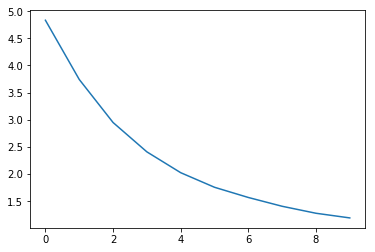

In [46]:
plt.plot(history.history['loss'])

### Plotting Validation Loss curve

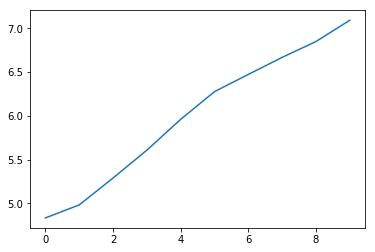

In [47]:
plt.plot(history.history['val_loss'])

### Saving the model to disk

In [48]:
model.save('keras_model_word.hdf5')
# loaded_model = keras.models.load_model('keras_model_word.hdf5')

### Loading the model

In [ ]:
model = keras.models.load_model('keras_model_word.hdf5')

In [53]:
def predict_n(seed_line, steps):
    '''
    function to generate lyrics from a seed line
    '''
    generated = []
    # sent=txt[start_index:start_index+maxlen]
    sent = [w for w in seed_line.split()]
    generated += sent[-maxlen:]
    print("#######################")
    print("Input - "," ".join(generated))
    gen = generated
    for i in range(steps):
        x_sample=generated[i:i+maxlen]
        x = np.zeros((1,maxlen,vocab_size))
        for k in range(maxlen):
            x[0,k,word_ix[x_sample[k]]] = 1
        probs = model.predict(x)[0]
        next_index = sample(probs, 0.5)
        next_word_pred = ix_word[next_index]
        generated.append(next_word_pred)
    print("Generated ############### ")
    print(" ".join(generated))

In [56]:
l = "i broke and fell in your arms in such a way\nlike a"

In [58]:
predict_n(l,100)

#######################
Input -  such a way like a
Generated ############### 
such a way like a few dreams 
 that you are not there 
 you are not there 
 you are not there 
 you are not there 
 you are not there 
 you are not there 
 you are not there 
 you are not that yet you are you in my dreams 
 
 you are a river 
 you hide in my breaths 
 
 ill keep you in my eyes 
 ill take care of you in my breaths 
 
 ill keep you in my eyes 
 ill take care of you in my breaths 
 
 
 keep


### Testing the model

In [ ]:
# txt = corpus
# start_index = 230
for j in range(0, 50, maxlen):
#     seed_index = np.random.randint(len(sentences_test))
    generated = []
    actual = []
    # sent=txt[start_index:start_index+maxlen]
    sent = sentences_test[j]
    generated += sent
    actual += sent
    print("#######################")
    print("Input - "," ".join(generated))
    gen = generated
    for i in range(100):
        x_sample=generated[i:i+maxlen]
        x = np.zeros((1,maxlen,vocab_size))
        for k in range(maxlen):
            x[0,k,word_ix[x_sample[k]]] = 1
        probs = model.predict(x)[0]
#         probs = np.reshape(probs,probs.shape[1])
#         ix = np.argmax(probs)
#         ix=np.random.choice(range(vocab_size),p=probs.ravel())
        next_index = sample(probs, 0.5)
        next_word_pred = ix_word[next_index]
        generated.append(next_word_pred)
        actual.append(next_words_test[j+i])
    print("Actual ###############")
    print(" ".join(actual))
    print()
    print("Generated ############### ")
    print(" ".join(generated))